In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [28]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
Fields are

ID : the id of the row used to link the mutation to the clinical evidence

Gene : the gene where this genetic mutation is located

Variation : the aminoacid change for this mutations

Class : 1-9 the class this genetic mutation has been classified on


3.1.2. Reading Text Data

In [29]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


3.1.3. Preprocessing of text

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/32fb0493-bd55-4ed4-9d59-1531ca0a584d/nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [32]:
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 64.27291297912598 seconds


In [33]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [34]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [35]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [36]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


3.1.4. Test, Train and Cross Validation Split

       3.1.4.1. Splitting data into train, test and cross validation (64:20:16)

In [37]:
y_true=result["Class"].values
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [38]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [39]:
#we want our class labels Yi to be roughly in all train , cv, and Test data, why?
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
print(type(train_class_distribution))
test_class_distribution = test_df['Class'].value_counts().sort_index()
print(test_class_distribution)
cv_class_distribution = cv_df['Class'].value_counts().sort_index()
print(cv_class_distribution)

<class 'pandas.core.series.Series'>
1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64
1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64


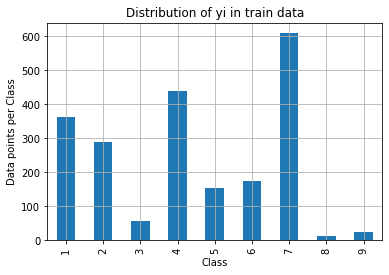

In [40]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Obervations: This is an imbalanced dataset as class 1,4 and 7 are dominating classes

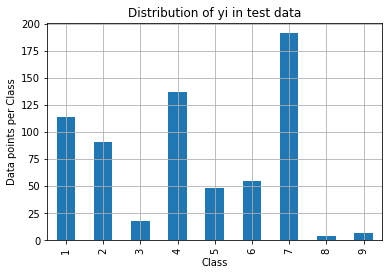

In [41]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

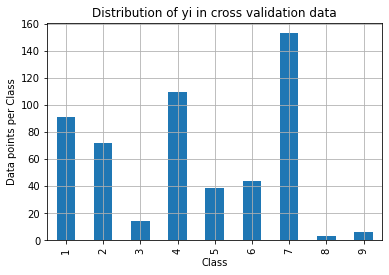

In [42]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

Observations: All these three datasets are imbalanced. Also the distributions of yi are same.

<h2>3.2 Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [43]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
  
    A =(((C.T)/(C.sum(axis=1))).T)
 
    
    B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5040523729862874
[[0.06382292 0.00716597 0.00941629 ... 0.19538959 0.17197111 0.18723802]
 [0.11116628 0.09054885 0.02781058 ... 0.02385923 0.14845428 0.16019278]
 [0.18419195 0.10987728 0.10724184 ... 0.19591851 0.01643225 0.14978582]
 ...
 [0.21296793 0.19032652 0.0499604  ... 0.0365548  0.06544512 0.1536758 ]
 [0.06936578 0.21480327 0.08131756 ... 0.02364808 0.00153685 0.2262585 ]
 [0.15521636 0.08217949 0.04893168 ... 0.23284396 0.04669306 0.0551944 ]]
Log loss on Test Data using Random Model 2.5184088620477785
[4 5 5 0 8 6 8 3 6 3 8 6 1 3 1 4 8 5 0 0 4 5 8 2 5 3 4 4 6 4 6 8 6 8 5 1 6
 5 0 7 2 6 3 2 5 6 8 2 3 2 7 7 4 4 2 8 2 6 6 2 6 7 6 5 0 6 3 0 6 1 7 5 2 2
 1 5 3 0 6 2 3 5 3 5 6 3 1 5 1 8 2 8 0 8 0 2 1 8 1 7 3 2 4 6 0 0 7 0 1 7 4
 2 4 1 3 7 2 5 2 4 5 5 0 5 3 3 5 2 7 0 1 5 4 2 4 3 2 1 3 7 2 0 7 7 3 5 6 2
 8 2 7 4 0 3 5 1 1 8 7 8 3 3 7 2 5 4 5 7 3 4 7 6 2 0 1 7 8 7 7 6 6 1 0 7 3
 2 8 7 4 4 0 1 7 5 7 2 0 0 3 6 0 8 6 6 2 3 3 8 8 

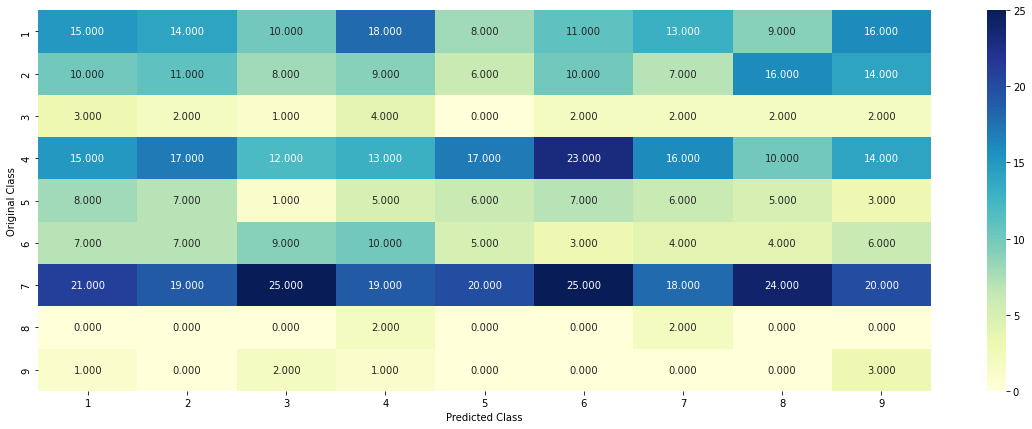

-------------------- Precision matrix (Columm Sum=1) --------------------


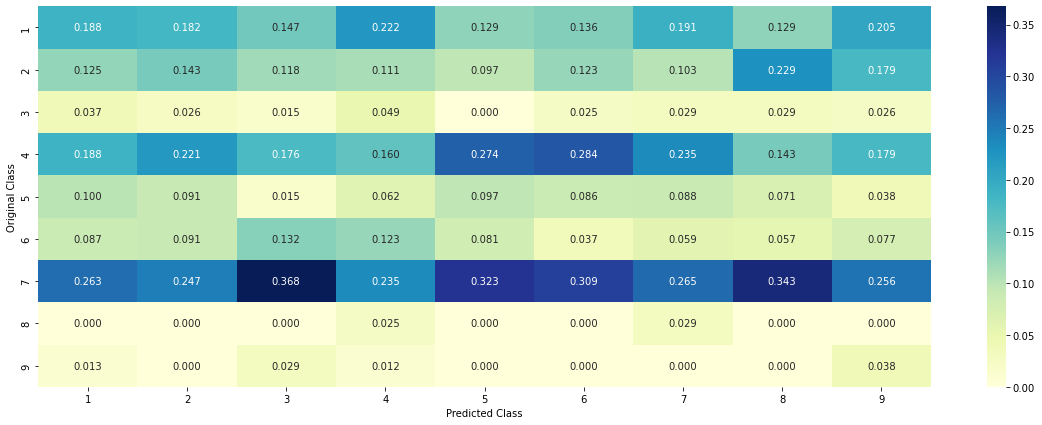

-------------------- Recall matrix (Row sum=1) --------------------


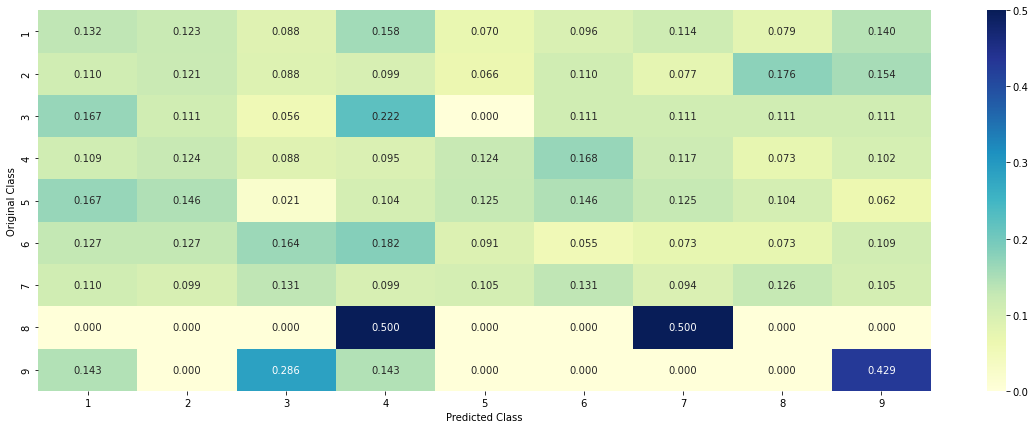

In [51]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print(test_predicted_y)
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
print(predicted_y)
plot_confusion_matrix(y_test, predicted_y+1)

Observation: The logloss on both the datasets is around 2.5. So a sensible model should have less than 2.5 as its log loss. This log loss on the random model will serve as a good comarator for future models

<h2>3.3 Univariate Analysis</h2>

<h3>3.2.1 Univariate Analysis on Gene Feature</h3>

In [53]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 228
BRCA1     164
TP53       92
EGFR       91
PTEN       89
BRCA2      85
KIT        62
BRAF       60
ERBB2      49
PDGFRA     42
ALK        39
Name: Gene, dtype: int64


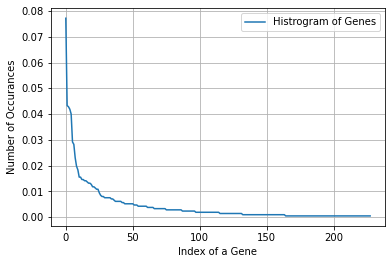

In [59]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
#print(h)
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


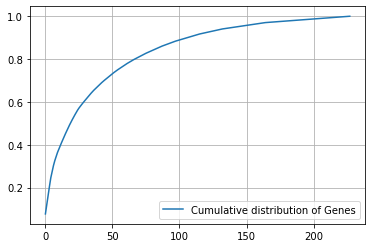

In [57]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Observation: Even though we have 228 genes, top 50 genes contribute to almost 75% of the data

In [60]:

def get_gv_fea_dict(alpha, feature, df):
   
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
     

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [61]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [62]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2012268986823351
For values of alpha =  0.0001 The log loss is: 1.1734945431572597
For values of alpha =  0.001 The log loss is: 1.2084822693820023
For values of alpha =  0.01 The log loss is: 1.307272826943188
For values of alpha =  0.1 The log loss is: 1.42720492843517
For values of alpha =  1 The log loss is: 1.4746642749074867


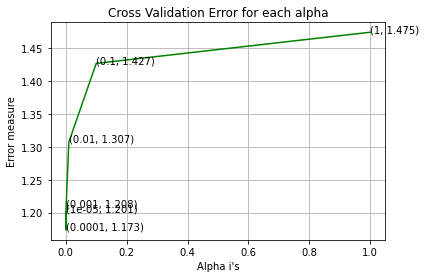

For values of best alpha =  0.0001 The train log loss is: 0.9889328875994181
For values of best alpha =  0.0001 The cross validation log loss is: 1.1734945431572597
For values of best alpha =  0.0001 The test log loss is: 1.1864788450837194


In [63]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

observations: 
1. Our model usiong only Gene Feature has less test and cv error than random model. Hence Gene feature is very useful

2. Also the gene is stable across all the data set as the loss is similar. Also no overfitting.

<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

In [64]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1943
Truncating Mutations    59
Deletion                43
Amplification           37
Fusions                 19
Q61R                     3
Q61H                     3
R173C                    2
Overexpression           2
R170W                    2
S308A                    2
Name: Variation, dtype: int64


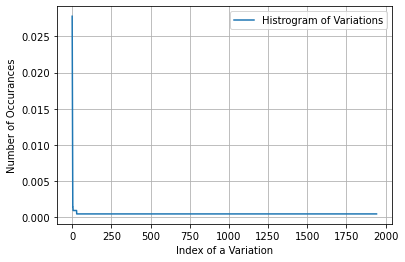

In [65]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02777778 0.0480226  0.06544256 ... 0.99905838 0.99952919 1.        ]


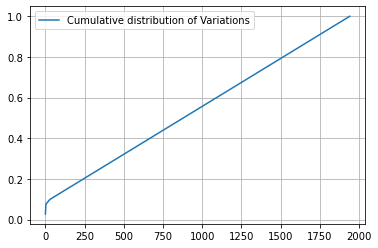

In [66]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

observations: most of the variations occur once or twice.

In [68]:
alpha=1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [69]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 The log loss is: 1.6889898209846899
For values of alpha =  0.0001 The log loss is: 1.6790745776383933
For values of alpha =  0.001 The log loss is: 1.690614381258016
For values of alpha =  0.01 The log loss is: 1.6998873706002424
For values of alpha =  0.1 The log loss is: 1.7160593390975434
For values of alpha =  1 The log loss is: 1.716145775766661


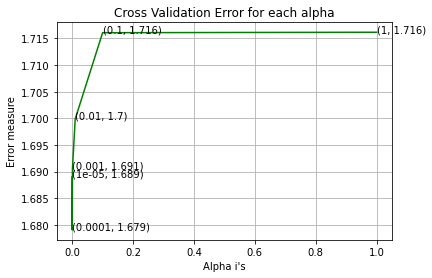

For values of best alpha =  0.0001 The train log loss is: 0.7515496990537028
For values of best alpha =  0.0001 The cross validation log loss is: 1.6790745776383933
For values of best alpha =  0.0001 The test log loss is: 1.676879181305397


In [70]:
alpha = [10 ** x for x in range(-5, 1)]




cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


observation: Variation feature is useful. its log loss is less than than RM. Its more unstable than the gene feature.

<h3>3.2.3 Univariate Analysis on Text Feature</h3>

How many unique words are present in train data?

How are word frequencies distributed?

How to featurize text field?

Is the text feature useful in predicitng y_i?

Is the text feature stable across train, test and CV datasets?


In [72]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [73]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [74]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53189


In [75]:
dict_list = []

for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [76]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [77]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [78]:

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [79]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

For values of alpha =  1e-05 The log loss is: 1.2692287331621048
For values of alpha =  0.0001 The log loss is: 1.1185530771794558
For values of alpha =  0.001 The log loss is: 1.1156021277479686
For values of alpha =  0.01 The log loss is: 1.2197731547101103
For values of alpha =  0.1 The log loss is: 1.3928652959521872
For values of alpha =  1 The log loss is: 1.654482903655949


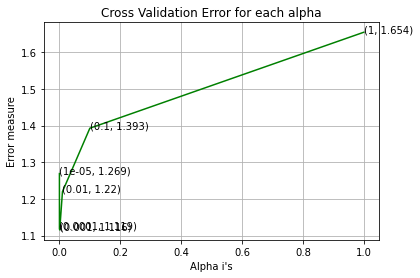

For values of best alpha =  0.001 The train log loss is: 0.6490033077468462
For values of best alpha =  0.001 The cross validation log loss is: 1.1156021277479686
For values of best alpha =  0.001 The test log loss is: 1.1632071994700193


In [81]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]




cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


observations: Text feature is the most useful feature of all the three features. 

<h1>4. Machine Learning Models</h1>

In [83]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [84]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [85]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [86]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [87]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55396)
(number of data points * number of features) in test data =  (665, 55396)
(number of data points * number of features) in cross validation data = (532, 55396)


In [88]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [89]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>
4.1.1.1. Hyper parameter tuning

for alpha = 1e-05
Log Loss : 1.2452722278613924e+00
for alpha = 0.0001
Log Loss : 1.2394857145186413e+00
for alpha = 0.001
Log Loss : 1.2403589354561713e+00
for alpha = 0.1
Log Loss : 1.2129353806999779e+00
for alpha = 1
Log Loss : 1.2422072161268074e+00
for alpha = 10
Log Loss : 1.3428354598271328e+00
for alpha = 100
Log Loss : 1.3012062918998963e+00
for alpha = 1000
Log Loss : 1.2675574028410288e+00


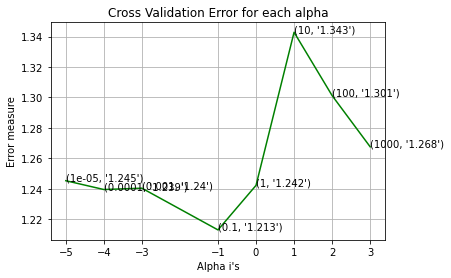

For values of best alpha =  0.1 The train log loss is: 8.569897519501534e-01
For values of best alpha =  0.1 The cross validation log loss is: 1.2129353806999779e+00
For values of best alpha =  0.1 The test log loss is: 1.2742648422620815e+00


In [90]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.2129353806999779e+00
Number of missclassified point : 0.37030075187969924
[[ 58   1   1   6  18   3   4   0   0]
 [  1  33   1   1   0   2  34   0   0]
 [  0   0   6   1   2   1   4   0   0]
 [ 33   3   1  54  10   4   4   0   1]
 [  7   0   0   2  23   3   4   0   0]
 [  6   1   0   0   2  28   7   0   0]
 [  1  21   2   1   0   0 128   0   0]
 [  0   1   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   1   0   5]]
[[0.63736264 0.01098901 0.01098901 0.06593407 0.1978022  0.03296703
  0.04395604 0.         0.        ]
 [0.01388889 0.45833333 0.01388889 0.01388889 0.         0.02777778
  0.47222222 0.         0.        ]
 [0.         0.         0.42857143 0.07142857 0.14285714 0.07142857
  0.28571429 0.         0.        ]
 [0.3        0.02727273 0.00909091 0.49090909 0.09090909 0.03636364
  0.03636364 0.         0.00909091]
 [0.17948718 0.         0.         0.05128205 0.58974359 0.07692308
  0.1025641  0.         0.        ]
 [0.13636364 0.02272727 0.         0.    

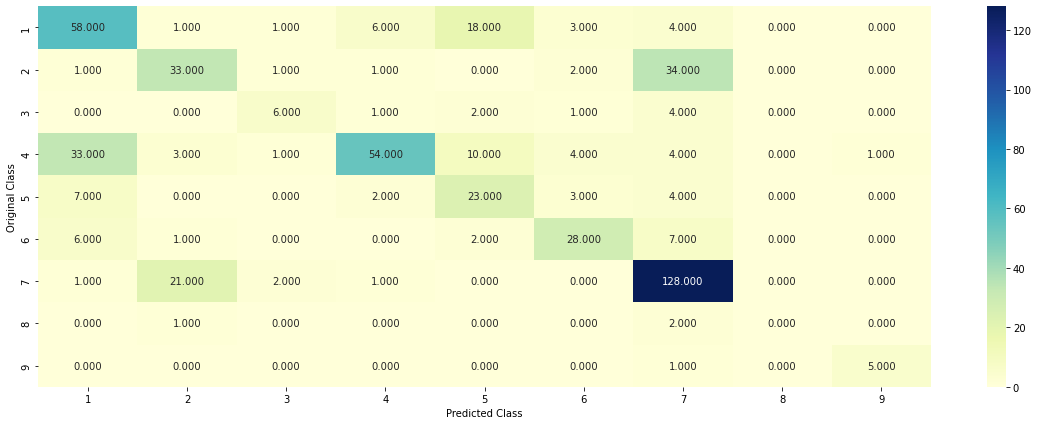

-------------------- Precision matrix (Columm Sum=1) --------------------


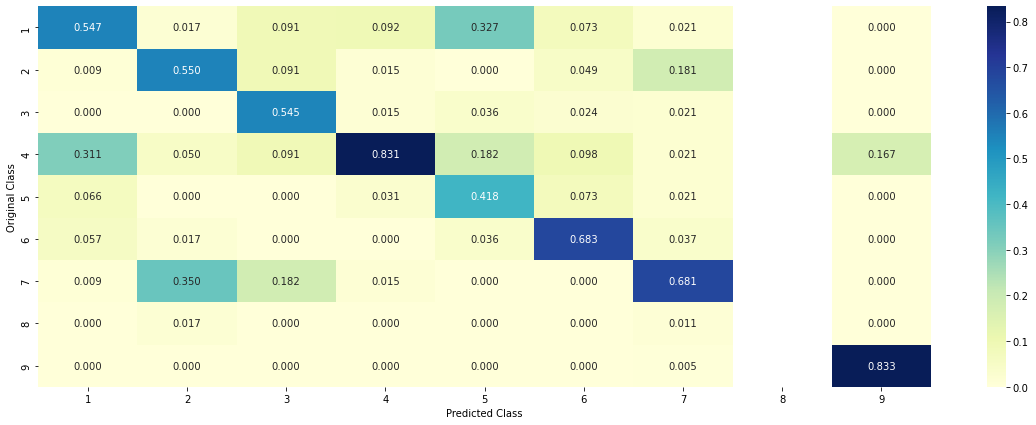

-------------------- Recall matrix (Row sum=1) --------------------


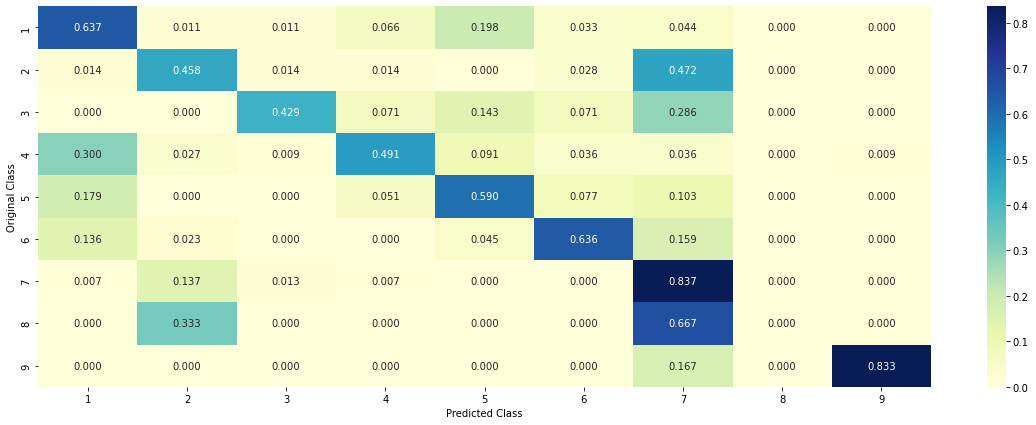

In [91]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [96]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0739 0.0671 0.0145 0.1031 0.0323 0.0333 0.6676 0.0041 0.0041]]
Actual Class : 7
--------------------------------------------------
18 Text feature [kinase] present in test data point [True]
20 Text feature [presence] present in test data point [True]
21 Text feature [inhibitor] present in test data point [True]
22 Text feature [expressing] present in test data point [True]
23 Text feature [activating] present in test data point [True]
24 Text feature [well] present in test data point [True]
25 Text feature [shown] present in test data point [True]
28 Text feature [previously] present in test data point [True]
29 Text feature [showed] present in test data point [True]
30 Text feature [independent] present in test data point [True]
31 Text feature [found] present in test data point [True]
32 Text feature [recently] present in test data point [True]
33 Text feature [however] present in test data point [True]
34 Text feature [cell] pre

<h2>4.2. K Nearest Neighbour Classification</h2>

Since we know KNN does not work well with HDD, we will use response coding instead of One hot Encoder.

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0667980853465138e+00
for alpha = 11
Log Loss : 1.0669404386552088
for alpha = 15
Log Loss : 1.0731654299659468
for alpha = 21
Log Loss : 1.0642862167538445
for alpha = 31
Log Loss : 1.073184283425074
for alpha = 41
Log Loss : 1.0818130681607254
for alpha = 51
Log Loss : 1.091009869982075
for alpha = 99
Log Loss : 1.1102625753089959


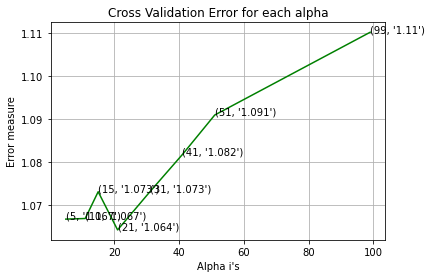

For values of best alpha =  21 The train log loss is: 0.734861148396357
For values of best alpha =  21 The cross validation log loss is: 1.0642862167538445
For values of best alpha =  21 The test log loss is: 1.07606883286469


In [97]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.0642862167538445
Number of mis-classified points : 0.39097744360902253
[[ 54   4   0  17  15   1   0   0   0]
 [  3  30   0   2   1   0  36   0   0]
 [  0   1   2   4   1   0   6   0   0]
 [ 28   2   0  68   8   0   4   0   0]
 [  5   0   0   7  19   3   5   0   0]
 [  7   4   0   2   2  24   5   0   0]
 [  1  22   4   3   0   0 123   0   0]
 [  0   3   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   1   0   4]]
[[0.59340659 0.04395604 0.         0.18681319 0.16483516 0.01098901
  0.         0.         0.        ]
 [0.04166667 0.41666667 0.         0.02777778 0.01388889 0.
  0.5        0.         0.        ]
 [0.         0.07142857 0.14285714 0.28571429 0.07142857 0.
  0.42857143 0.         0.        ]
 [0.25454545 0.01818182 0.         0.61818182 0.07272727 0.
  0.03636364 0.         0.        ]
 [0.12820513 0.         0.         0.17948718 0.48717949 0.07692308
  0.12820513 0.         0.        ]
 [0.15909091 0.09090909 0.         0.04545455 0.04545455 0.54545455


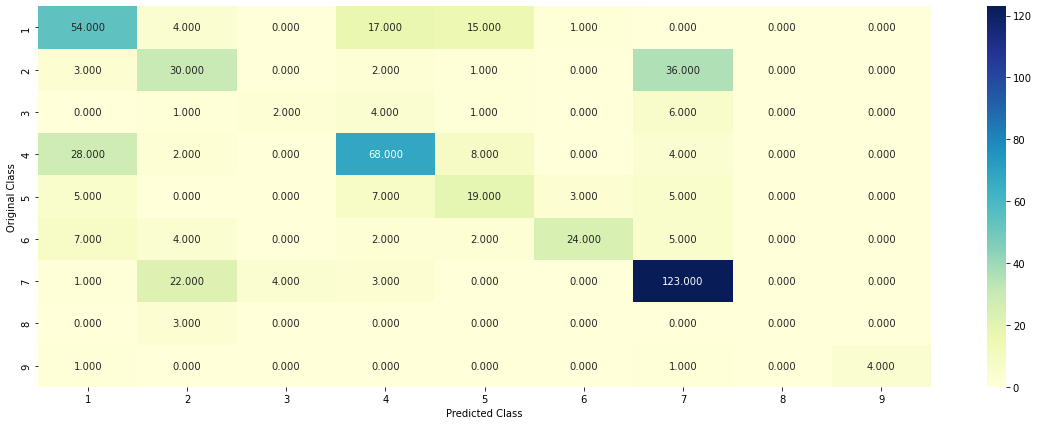

-------------------- Precision matrix (Columm Sum=1) --------------------


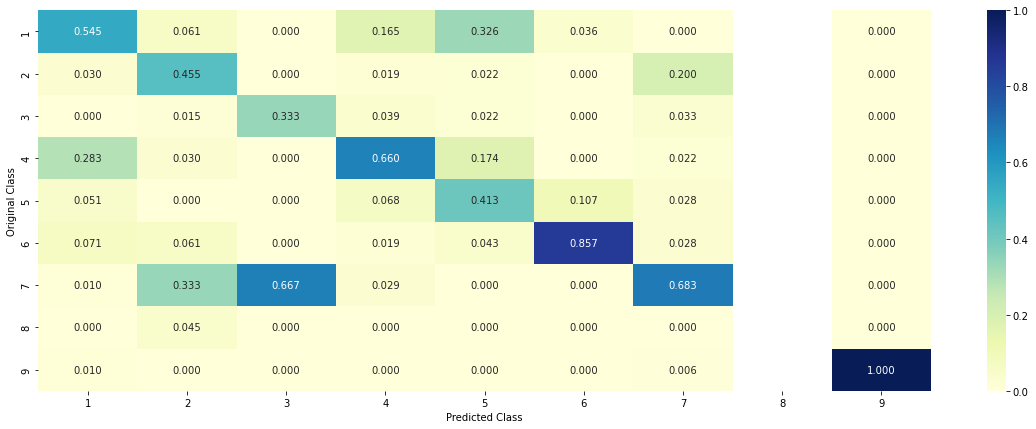

-------------------- Recall matrix (Row sum=1) --------------------


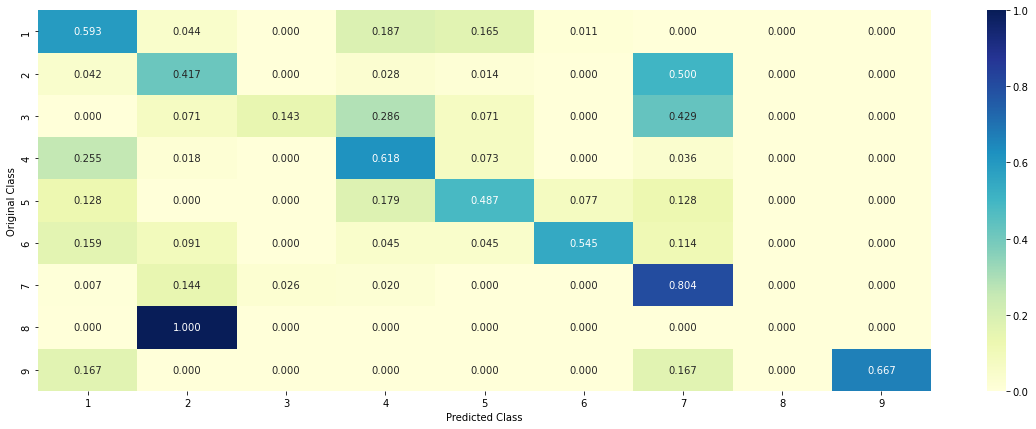

In [98]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [99]:
#We can't get feature importnace easily in KNN as opposed to other algorithms. But we can get interpretability into the model.

<h3>4.2.3.Sample Query point -1</h3>

In [106]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 6
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 7
The  21  nearest neighbours of the test points belongs to classes [7 7 7 7 7 2 2 7 7 7 7 7 2 6 7 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 17, 2: 3, 6: 1})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

#LR works well in high dimensional data becoz its easier to find plane in HDD that seperates our classes.
#we have an imbalaned data set. so we use class balancing. 

for alpha = 1e-06
Log Loss : 1.2634606262743988
for alpha = 1e-05
Log Loss : 1.2214863469870367
for alpha = 0.0001
Log Loss : 1.0732772853769406
for alpha = 0.001
Log Loss : 1.031190254308968
for alpha = 0.01
Log Loss : 1.0677841648756916
for alpha = 0.1
Log Loss : 1.375044768077137
for alpha = 1
Log Loss : 1.6489292669711102
for alpha = 10
Log Loss : 1.683985945639236
for alpha = 100
Log Loss : 1.6875863744071418


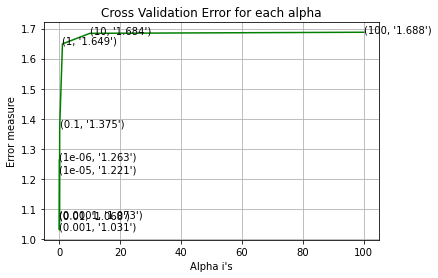

For values of best alpha =  0.001 The train log loss is: 0.5195807387955153
For values of best alpha =  0.001 The cross validation log loss is: 1.031190254308968
For values of best alpha =  0.001 The test log loss is: 1.0651624116690708


In [107]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Testing 

Log loss : 1.031190254308968
Number of mis-classified points : 0.3176691729323308
[[ 64   1   0  13   6   2   5   0   0]
 [  3  29   0   1   0   0  39   0   0]
 [  0   0   7   3   0   0   4   0   0]
 [ 21   1   0  80   3   0   5   0   0]
 [ 14   0   0   5  13   3   4   0   0]
 [  6   1   0   2   1  28   6   0   0]
 [  1   9   2   2   0   0 139   0   0]
 [  0   1   0   0   0   0   2   0   0]
 [  0   0   0   2   0   0   1   0   3]]
[[0.7032967  0.01098901 0.         0.14285714 0.06593407 0.02197802
  0.05494505 0.         0.        ]
 [0.04166667 0.40277778 0.         0.01388889 0.         0.
  0.54166667 0.         0.        ]
 [0.         0.         0.5        0.21428571 0.         0.
  0.28571429 0.         0.        ]
 [0.19090909 0.00909091 0.         0.72727273 0.02727273 0.
  0.04545455 0.         0.        ]
 [0.35897436 0.         0.         0.12820513 0.33333333 0.07692308
  0.1025641  0.         0.        ]
 [0.13636364 0.02272727 0.         0.04545455 0.02272727 0.63636364
  

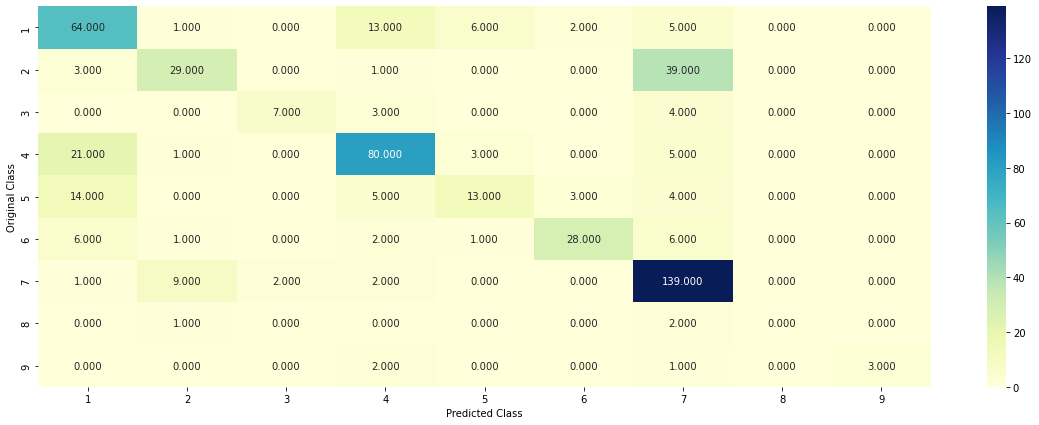

-------------------- Precision matrix (Columm Sum=1) --------------------


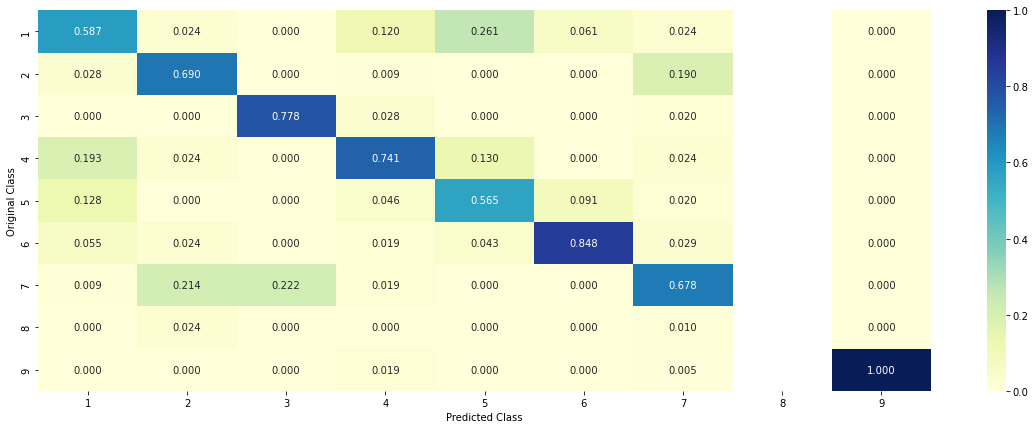

-------------------- Recall matrix (Row sum=1) --------------------


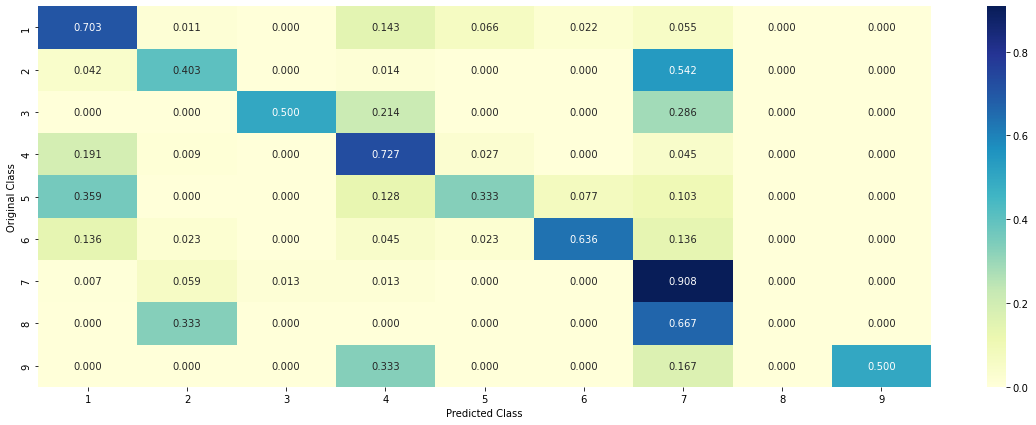

In [108]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

observations: Due to class balance, class 6,8,9 etc also start participating.
For imbalance, we are doing over sampling technique here.

<h4>4.3.1.3. Feature Importance</h4>

In [109]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [110]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0056 0.2728 0.0019 0.6399 0.0048 0.051  0.0171 0.0044 0.0025]]
Actual Class : 4
--------------------------------------------------
138 Text feature [apotosis] present in test data point [True]
154 Text feature [activating] present in test data point [True]
200 Text feature [approx2] present in test data point [True]
235 Text feature [jnks] present in test data point [True]
243 Text feature [devoid] present in test data point [True]
244 Text feature [suppressor] present in test data point [True]
281 Text feature [stk11] present in test data point [True]
293 Text feature [monolayers] present in test data point [True]
325 Text feature [harboring] present in test data point [True]
342 Text feature [dn] present in test data point [True]
353 Text feature [hypophosphorylated] present in test data point [True]
412 Text feature [screen] present in test data point [True]
488 Text feature [inhibitor] present in test data point [True]
493 Text

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2782082409876834
for alpha = 1e-05
Log Loss : 1.1918225860919844
for alpha = 0.0001
Log Loss : 1.07940796384365
for alpha = 0.001
Log Loss : 1.047262042583522
for alpha = 0.01
Log Loss : 1.1425901038236423
for alpha = 0.1
Log Loss : 1.2798825991318101
for alpha = 1
Log Loss : 1.5926449843898927


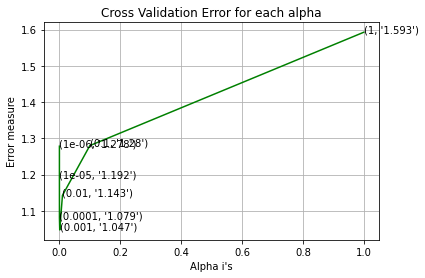

For values of best alpha =  0.001 The train log loss is: 0.5139988981856135
For values of best alpha =  0.001 The cross validation log loss is: 1.047262042583522
For values of best alpha =  0.001 The test log loss is: 1.0854636690006922


In [111]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.047262042583522
Number of mis-classified points : 0.325187969924812
[[ 64   1   0  13   6   2   5   0   0]
 [  3  29   0   1   0   0  39   0   0]
 [  0   0   1   5   0   0   8   0   0]
 [ 21   2   0  79   3   0   5   0   0]
 [ 15   0   0   5  12   3   4   0   0]
 [  6   2   0   2   1  28   5   0   0]
 [  1   9   0   2   0   0 141   0   0]
 [  0   1   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   1   0   5]]
[[0.7032967  0.01098901 0.         0.14285714 0.06593407 0.02197802
  0.05494505 0.         0.        ]
 [0.04166667 0.40277778 0.         0.01388889 0.         0.
  0.54166667 0.         0.        ]
 [0.         0.         0.07142857 0.35714286 0.         0.
  0.57142857 0.         0.        ]
 [0.19090909 0.01818182 0.         0.71818182 0.02727273 0.
  0.04545455 0.         0.        ]
 [0.38461538 0.         0.         0.12820513 0.30769231 0.07692308
  0.1025641  0.         0.        ]
 [0.13636364 0.04545455 0.         0.04545455 0.02272727 0.63636364
  0

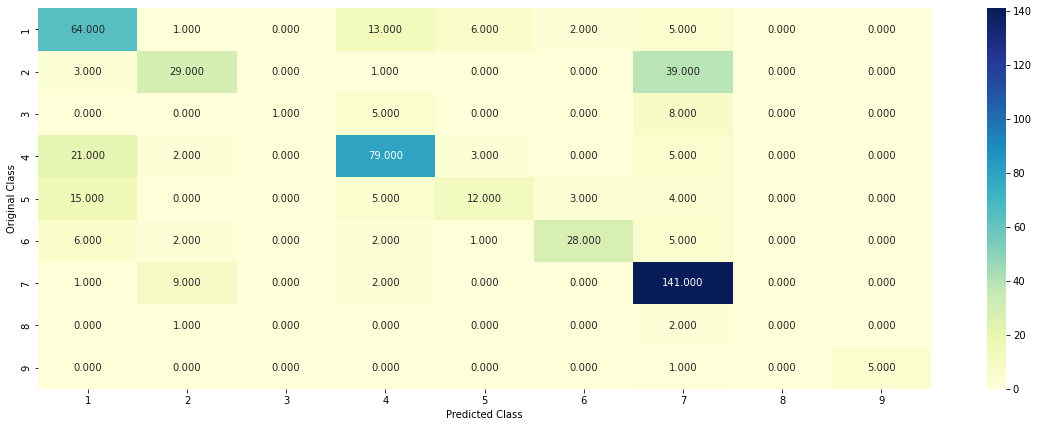

-------------------- Precision matrix (Columm Sum=1) --------------------


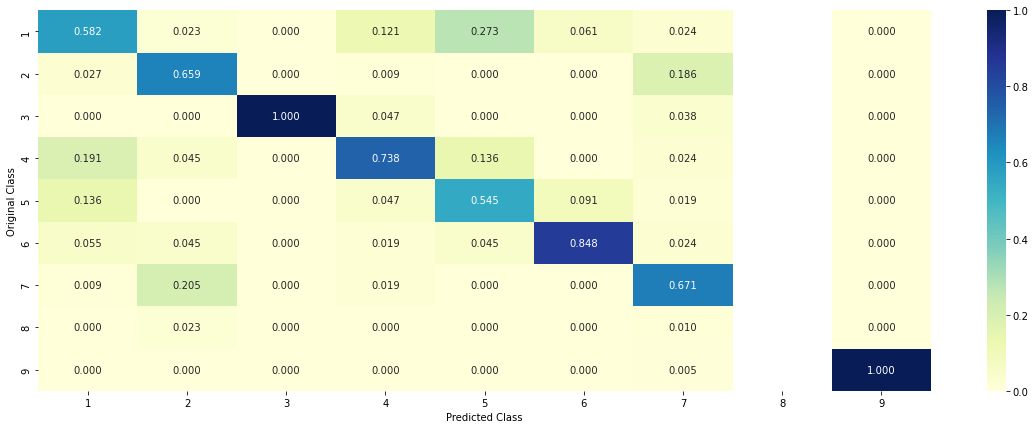

-------------------- Recall matrix (Row sum=1) --------------------


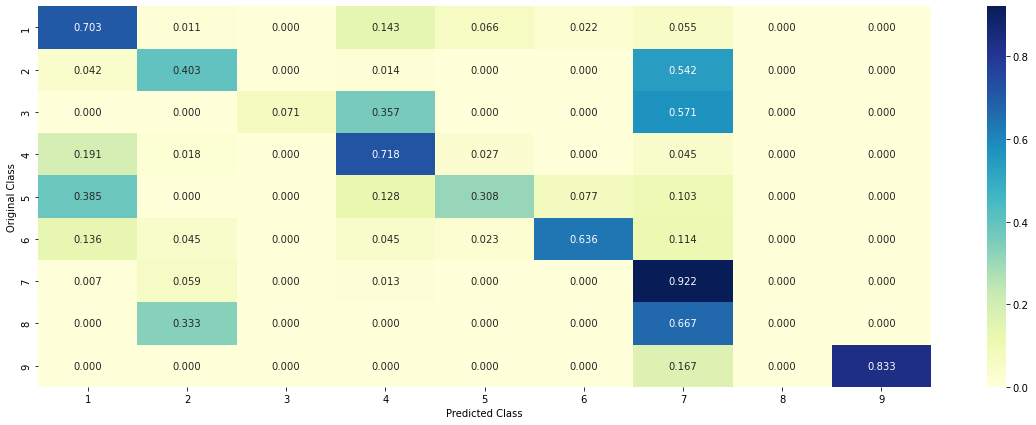

In [115]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [116]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[5.900e-03 2.596e-01 1.300e-03 6.552e-01 4.200e-03 4.740e-02 2.290e-02
  2.800e-03 6.000e-04]]
Actual Class : 4
--------------------------------------------------
192 Text feature [apotosis] present in test data point [True]
216 Text feature [approx2] present in test data point [True]
235 Text feature [jnks] present in test data point [True]
251 Text feature [stk11] present in test data point [True]
268 Text feature [devoid] present in test data point [True]
284 Text feature [monolayers] present in test data point [True]
285 Text feature [activating] present in test data point [True]
328 Text feature [suppressor] present in test data point [True]
406 Text feature [dn] present in test data point [True]
457 Text feature [hypophosphorylated] present in test data point [True]
467 Text feature [mkk4] present in test data point [True]
Out of the top  500  features  11 are present in query point


observation: Missclassification error is bit more without class balancing.

<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2512723252256728
for C = 0.0001
Log Loss : 1.1790732392734016
for C = 0.001
Log Loss : 1.0736995645824752
for C = 0.01
Log Loss : 1.0770631705883915
for C = 0.1
Log Loss : 1.2981256675615778
for C = 1
Log Loss : 1.6728102697389589
for C = 10
Log Loss : 1.6881897428676969
for C = 100
Log Loss : 1.688189798991223


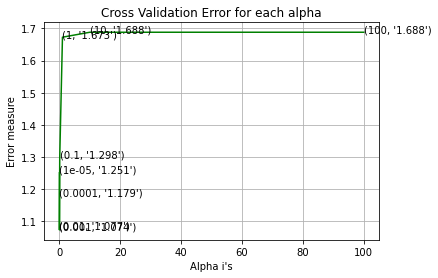

For values of best alpha =  0.001 The train log loss is: 0.5264921962474384
For values of best alpha =  0.001 The cross validation log loss is: 1.0736995645824752
For values of best alpha =  0.001 The test log loss is: 1.1390086629727032


In [117]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [119]:


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.248046980380409
for n_estimators = 100 and max depth =  10
Log Loss : 1.1741539528804297
for n_estimators = 200 and max depth =  5
Log Loss : 1.2317566792134091
for n_estimators = 200 and max depth =  10
Log Loss : 1.15524494411964
for n_estimators = 500 and max depth =  5
Log Loss : 1.2247496480602844
for n_estimators = 500 and max depth =  10
Log Loss : 1.1566197491068457
for n_estimators = 1000 and max depth =  5
Log Loss : 1.224361153650679
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1546260139242324
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2234800553863714
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1547553425192967
For values of best estimator =  1000 The train log loss is: 0.7039950441427654
For values of best estimator =  1000 The cross validation log loss is: 1.1546260139242324
For values of best estimator =  1000 The test log loss is: 1.1644398273904062


<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1546260139242324
Number of mis-classified points : 0.40037593984962405
[[ 65   0   0  16   1   0   9   0   0]
 [  1  25   0   6   0   0  40   0   0]
 [  1   0   1   4   0   0   8   0   0]
 [ 18   0   0  76   0   0  16   0   0]
 [ 18   0   0  13   1   0   7   0   0]
 [  8   4   0   3  13  10   6   0   0]
 [  4   9   0   2   0   0 138   0   0]
 [  1   0   0   1   0   0   1   0   0]
 [  0   0   0   2   0   0   1   0   3]]
[[0.71428571 0.         0.         0.17582418 0.01098901 0.
  0.0989011  0.         0.        ]
 [0.01388889 0.34722222 0.         0.08333333 0.         0.
  0.55555556 0.         0.        ]
 [0.07142857 0.         0.07142857 0.28571429 0.         0.
  0.57142857 0.         0.        ]
 [0.16363636 0.         0.         0.69090909 0.         0.
  0.14545455 0.         0.        ]
 [0.46153846 0.         0.         0.33333333 0.02564103 0.
  0.17948718 0.         0.        ]
 [0.18181818 0.09090909 0.         0.06818182 0.29545455 0.22727273
  0.13636364 0. 

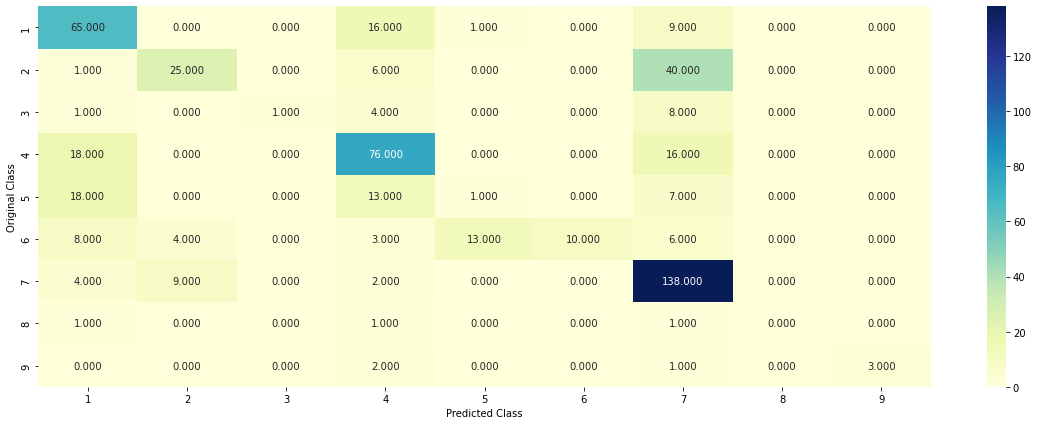

-------------------- Precision matrix (Columm Sum=1) --------------------


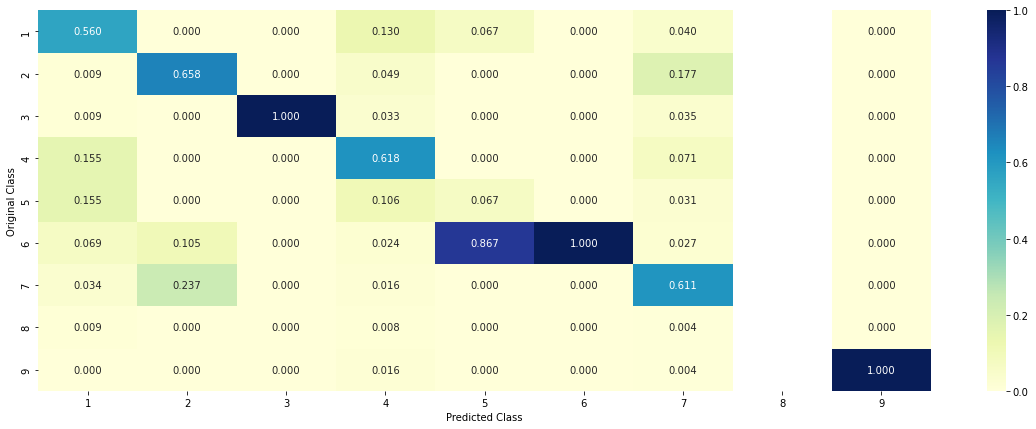

-------------------- Recall matrix (Row sum=1) --------------------


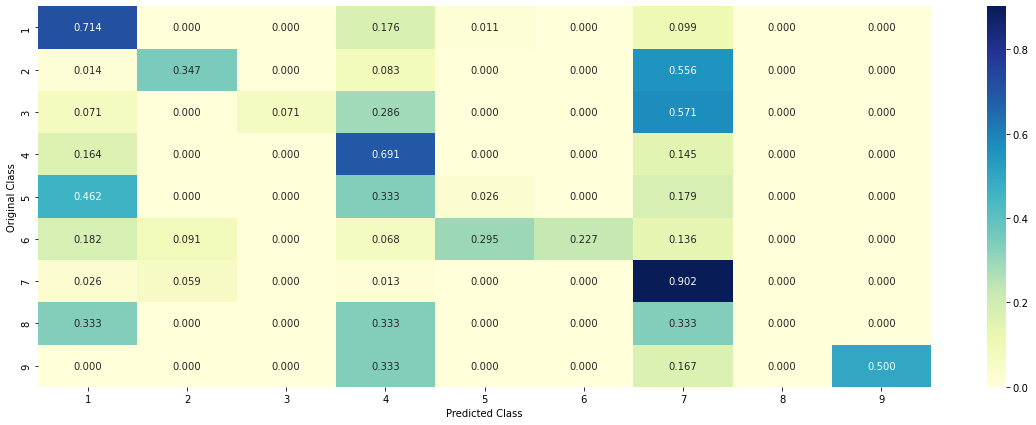

In [120]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly Classified point</h4>

In [122]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1021 0.1169 0.0222 0.2133 0.0524 0.0438 0.4336 0.0067 0.009 ]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [constitutive] present in test data point [True]
4 Text feature [phosphorylation] present in test data point [True]
5 Text feature [activation] present in test data point [True]
7 Text feature [signaling] present in test data point [True]
8 Text feature [activated] present in test data point [True]
9 Text feature [erk] present in test data point [True]
10 Text feature [function] present in test data point [True]
11 Text feature [suppressor] present in test data point [True]
13 Text feature [missense] present in test data point [True]
14 Text feature [treatment] present in test data point [True]
15 Text feature [

we can clearly see that out of all models we created, logistic regression gave us lowest misclassification rate of while also being interpretible.